# Load Dataset

In [14]:
# data
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore") 

# visualization
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
import seaborn as sns
%matplotlib inline

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# model
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift, estimate_bandwidth

# grid search
from sklearn.model_selection import GridSearchCV

# evaluation
from sklearn.metrics.cluster import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import *

In [15]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [16]:
del df["CustomerID"]

In [17]:
df['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [18]:
df['Gender'].replace({'Male':1, 'Female':0},inplace=True)

In [19]:
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


In [20]:
df.shape

(200, 4)

# EDA

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Gender                  200 non-null    int64
 1   Age                     200 non-null    int64
 2   Annual Income (k$)      200 non-null    int64
 3   Spending Score (1-100)  200 non-null    int64
dtypes: int64(4)
memory usage: 6.4 KB


In [22]:
df.isnull().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [23]:
df.describe()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,0.440000,38.850000,60.560000,50.200000
std,0.497633,13.969007,26.264721,25.823522
min,0.000000,18.000000,15.000000,1.000000
25%,0.000000,28.750000,41.500000,34.750000
50%,0.000000,36.000000,61.500000,50.000000
75%,1.000000,49.000000,78.000000,73.000000
max,1.000000,70.000000,137.000000,99.000000


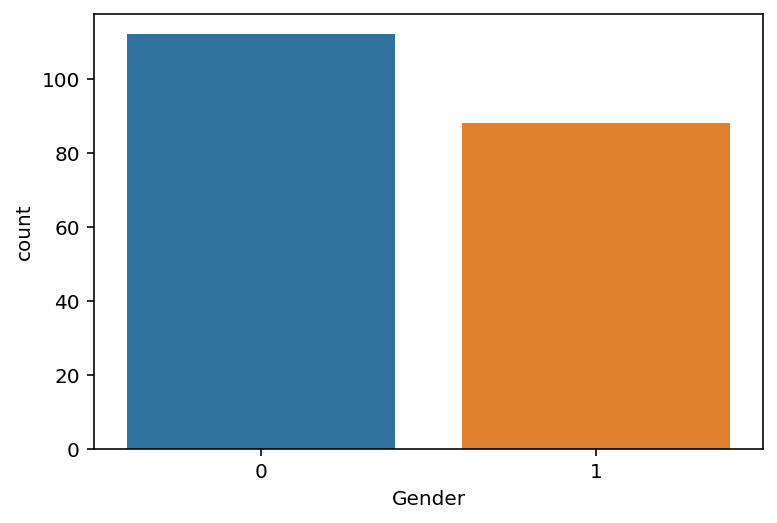

In [24]:
sns.countplot('Gender' , data = df)
plt.show()

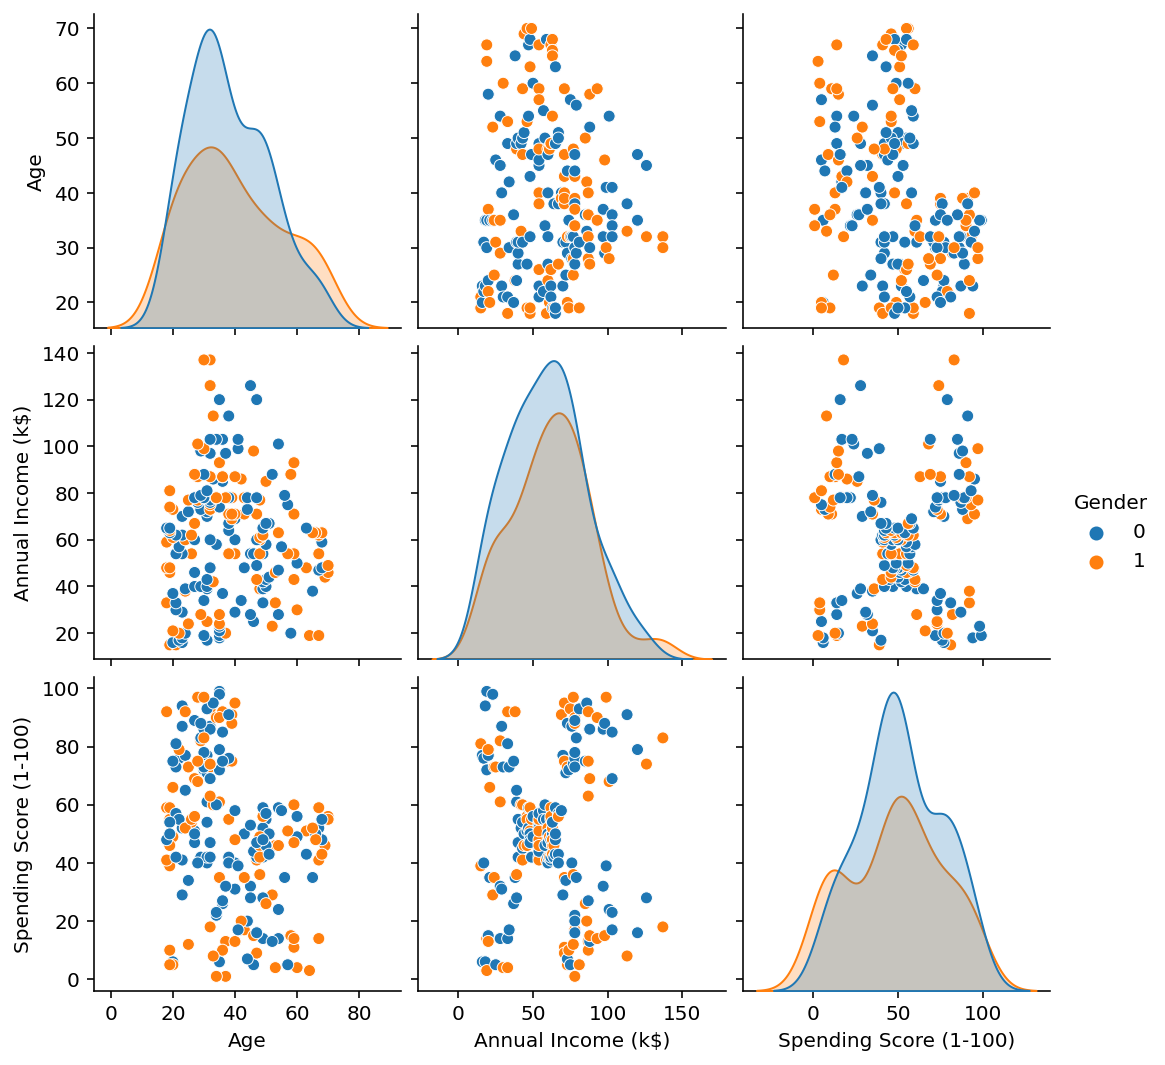

In [25]:
sns.pairplot(df, hue="Gender")
plt.show()

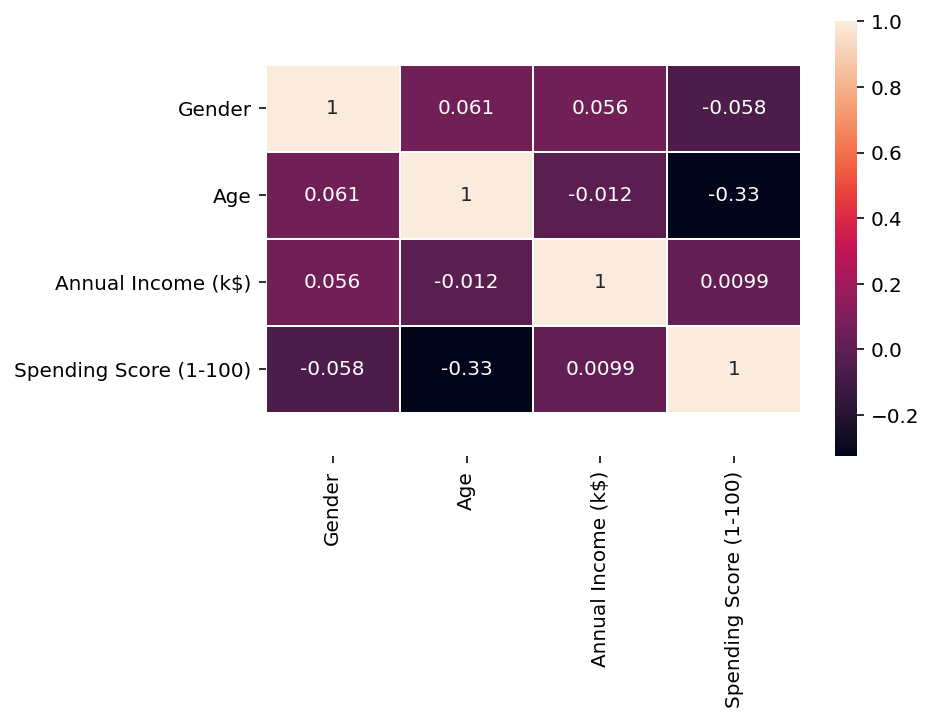

In [26]:
g = sns.heatmap(df.corr(), annot=True, linewidths=.5)
bottom, top = g.get_ylim() # heatmap plot이 잘리는 것 방지하기 위한 방법
g.set_ylim(bottom+0.5, top-0.5)
plt.show()

# Modeling

## PCA

In [27]:
pca = PCA(n_components=2)
reduced_df = pca.fit_transform(df)
reduced_df.shape

(200, 2)

* 평면에 시각화를 위해 PCA를 이용해 2차원으로 차원 축소를 진행하였다.
* 평가는 시각화 및 Silhouette Coefficient, Davies bouldin score로 진행하였다.
* Silhouette Coefficient는 실루엣 계수로 -1 부터 1사이의 값을 가지며 1에 가까울 수록 최적화된 군집이라고 할 수 있다.
* Davies Bouldin Index는 Group 내에서의 Distribution과 비교하여 다른 Group간의 분리 정도의 비율로 계산되는 값으로 모든 두 개의 Group 쌍에 대해 각 Group의 크기의 합을 각 Group의 중심 간 거리로 나눈 값으로서 표현되는 함수이다. 즉, 값이 작을수록 최적화된 군집이라고 할 수 있다.

## 1. K-Means

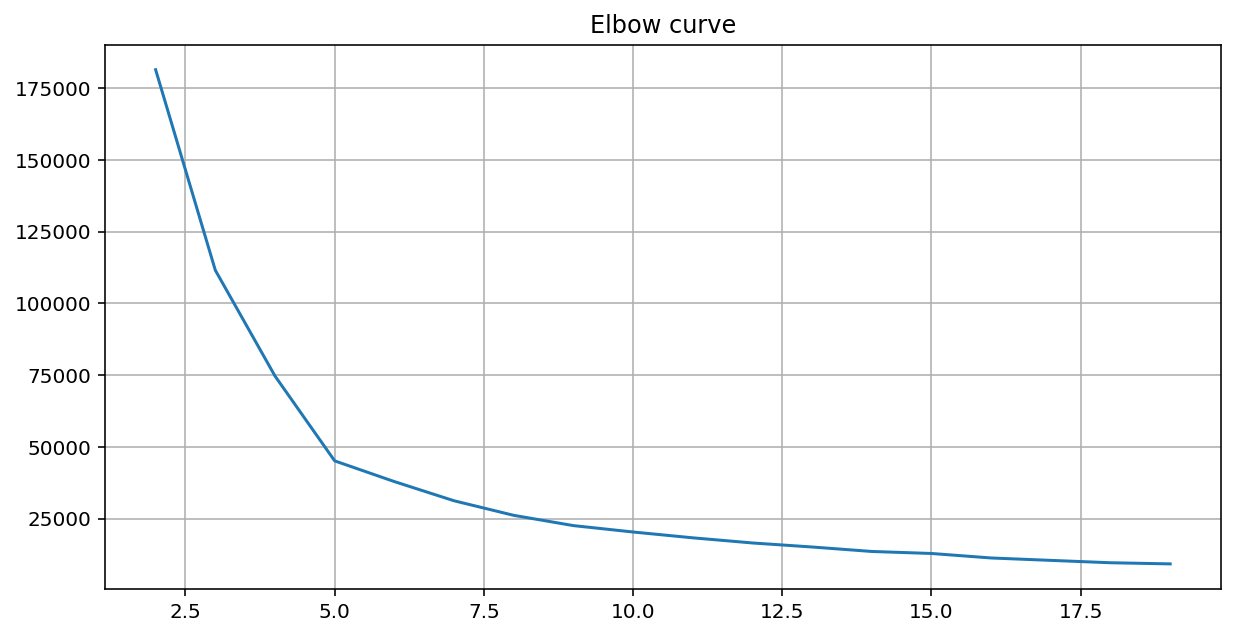

In [28]:
distortions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(reduced_df)
    distortions.append(kmeans.inertia_)

fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, 20), distortions)
plt.grid(True)
plt.title('Elbow curve')
plt.show()

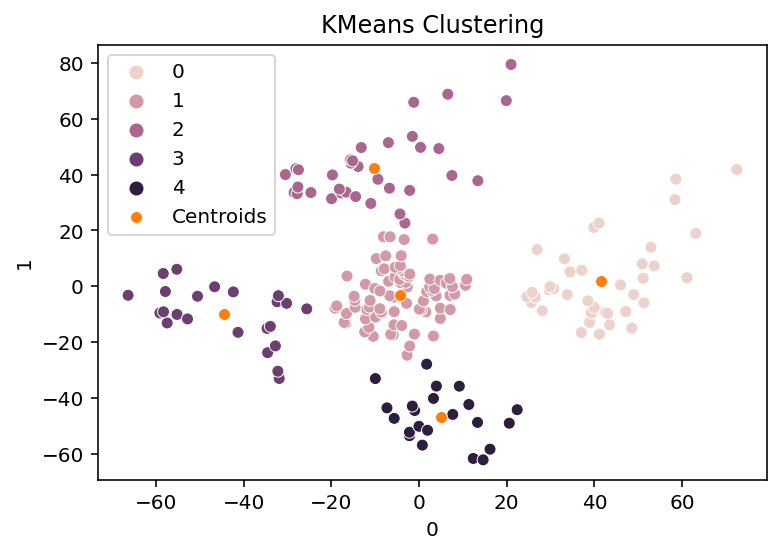

Silhouette Coefficient: 0.5526
Davies Bouldin Index: 0.5843


In [29]:
reduced_df = pd.DataFrame(reduced_df)

km = KMeans(n_clusters=5, init='k-means++')
cluster = km.fit(reduced_df)
cluster_id = pd.DataFrame(cluster.labels_)

d1 = pd.concat([reduced_df, cluster_id], axis=1)
d1.columns = [0, 1, "cluster"]

sns.scatterplot(d1[0], d1[1], hue = d1['cluster'], legend="full")
sns.scatterplot(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], label = 'Centroids')
plt.title("KMeans Clustering")
plt.legend()
plt.show()

print('Silhouette Coefficient: {:.4f}'.format(metrics.silhouette_score(d1.iloc[:,:-1], d1['cluster'])))
print('Davies Bouldin Index: {:.4f}'.format(metrics.davies_bouldin_score(d1.iloc[:,:-1], d1['cluster'])))

## 2. DBScan

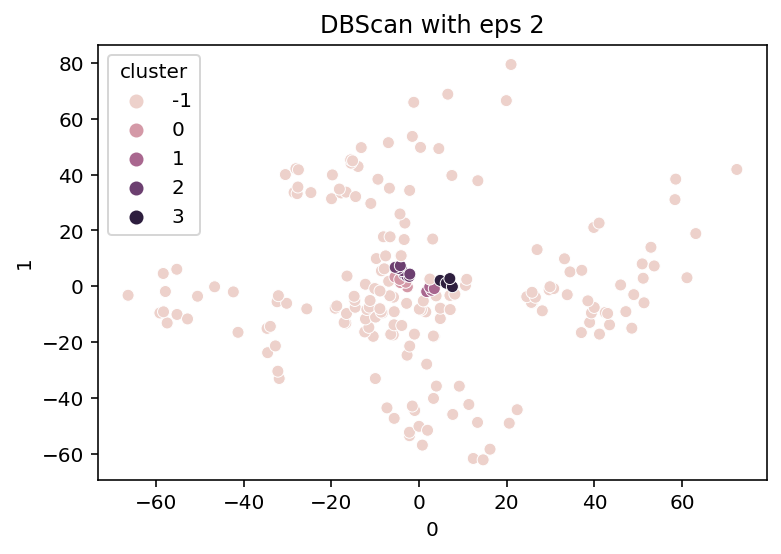

Silhouette Coefficient: -0.3259
Davies Bouldin Index: 9.0856


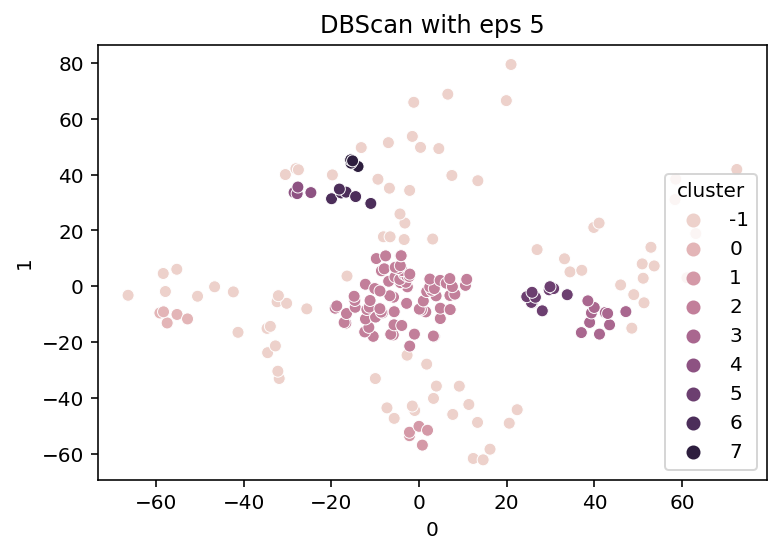

Silhouette Coefficient: 0.0896
Davies Bouldin Index: 2.1779


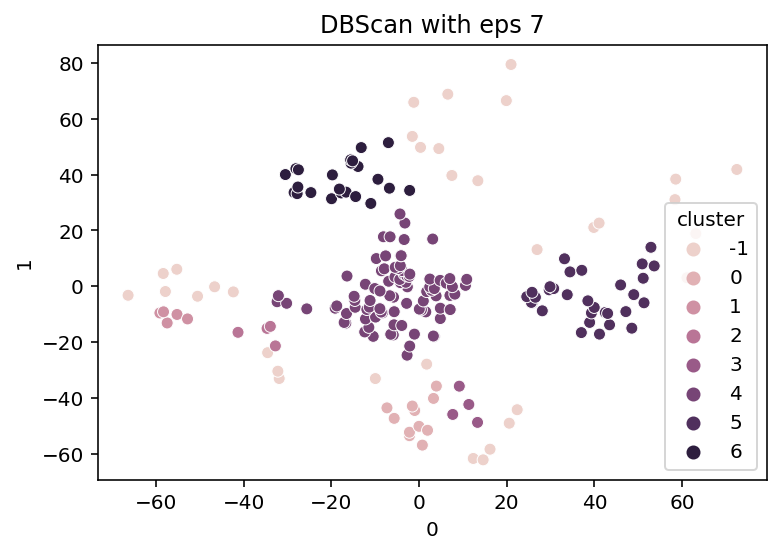

Silhouette Coefficient: 0.3060
Davies Bouldin Index: 2.1851


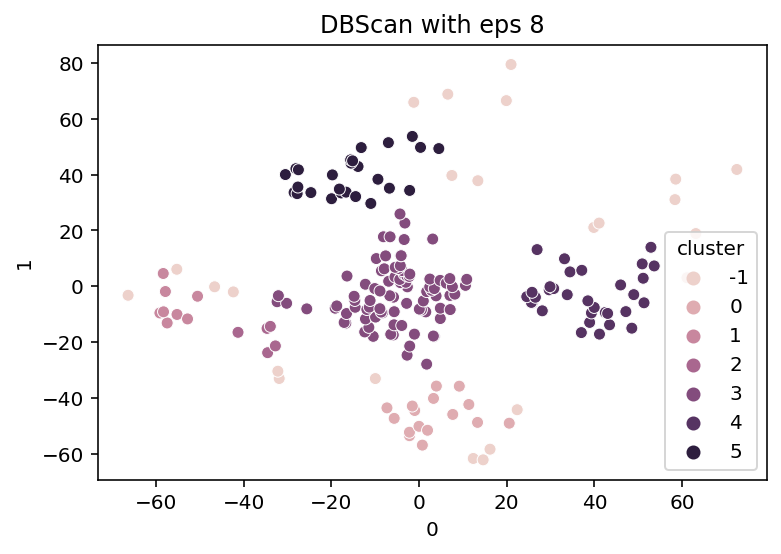

Silhouette Coefficient: 0.3944
Davies Bouldin Index: 2.0000


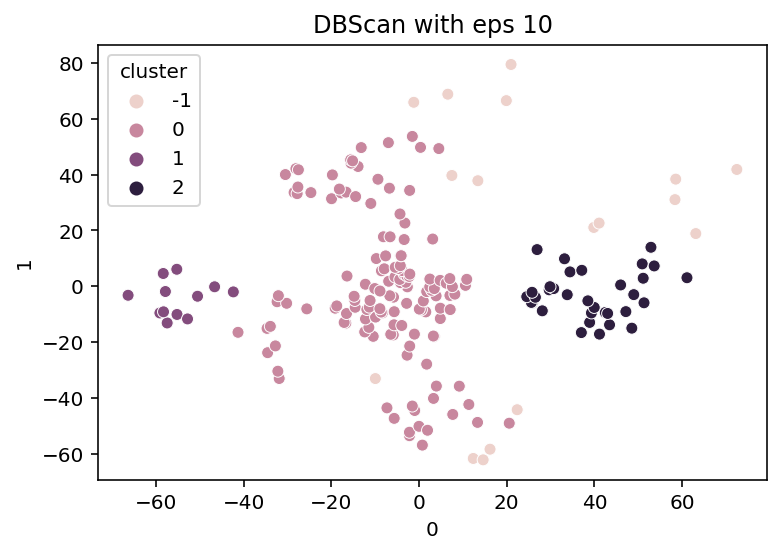

Silhouette Coefficient: 0.3124
Davies Bouldin Index: 1.9782


In [30]:
eps = [2,5,7,8,10]
for i in eps:
    db = DBSCAN(eps=i, min_samples=4)
    cluster = db.fit(reduced_df)
    cluster_id = pd.DataFrame(cluster.labels_)
    
    d2 = pd.DataFrame()
    d2 = pd.concat([reduced_df,cluster_id],axis=1)
    d2.columns = [0, 1, "cluster"]
    
    sns.scatterplot(d2[0], d2[1], hue = d2['cluster'], legend="full")
    plt.title('DBScan with eps {}'.format(i))
    plt.show()
    
    print('Silhouette Coefficient: {:.4f}'.format(metrics.silhouette_score(d2.iloc[:,:-1], d2['cluster'])))
    print('Davies Bouldin Index: {:.4f}'.format(metrics.davies_bouldin_score(d2.iloc[:,:-1], d2['cluster'])))

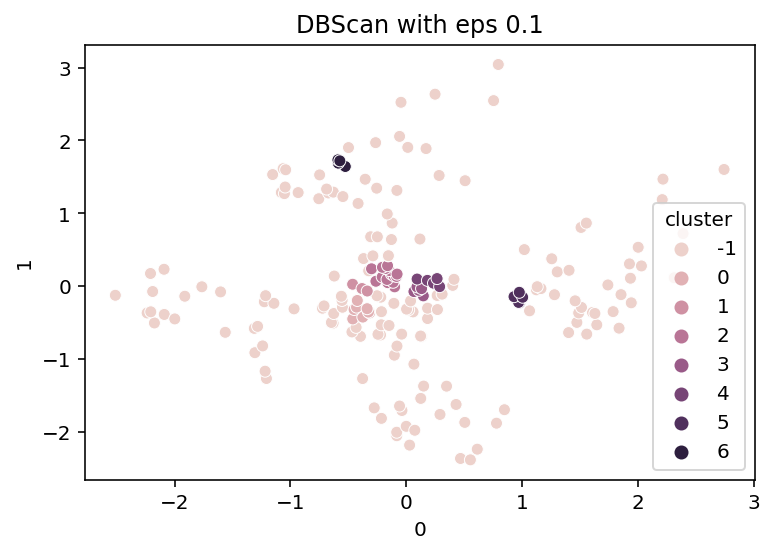

Silhouette Coefficient: -0.3248
Davies Bouldin Index: 6.5649


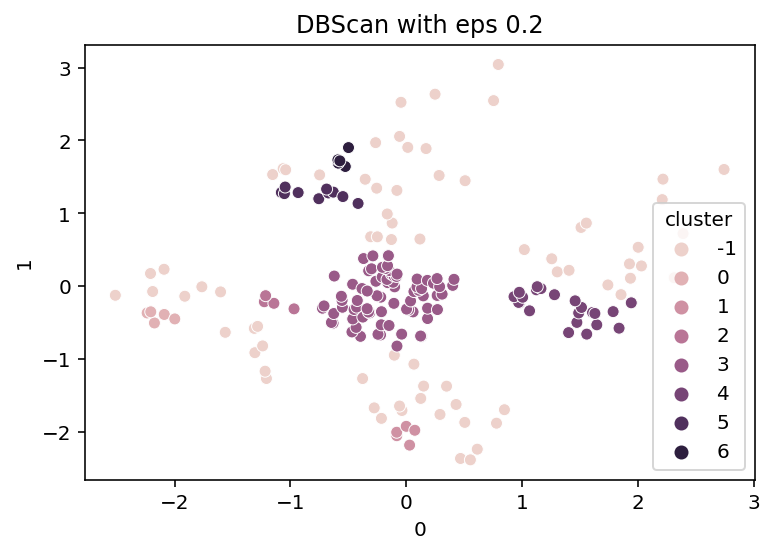

Silhouette Coefficient: 0.0994
Davies Bouldin Index: 2.2154


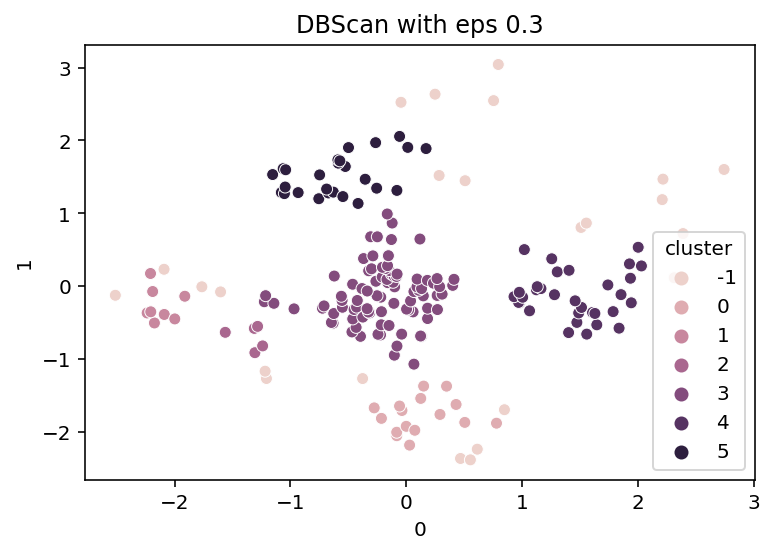

Silhouette Coefficient: 0.3939
Davies Bouldin Index: 2.0034


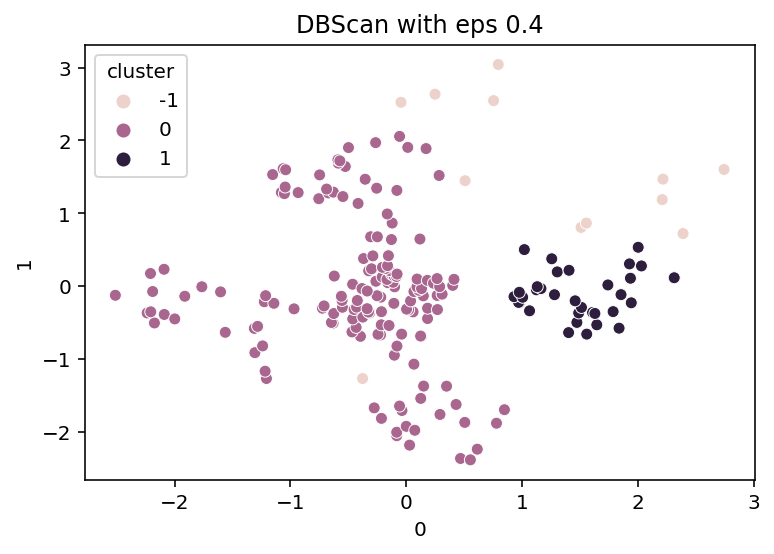

Silhouette Coefficient: 0.3298
Davies Bouldin Index: 1.0988


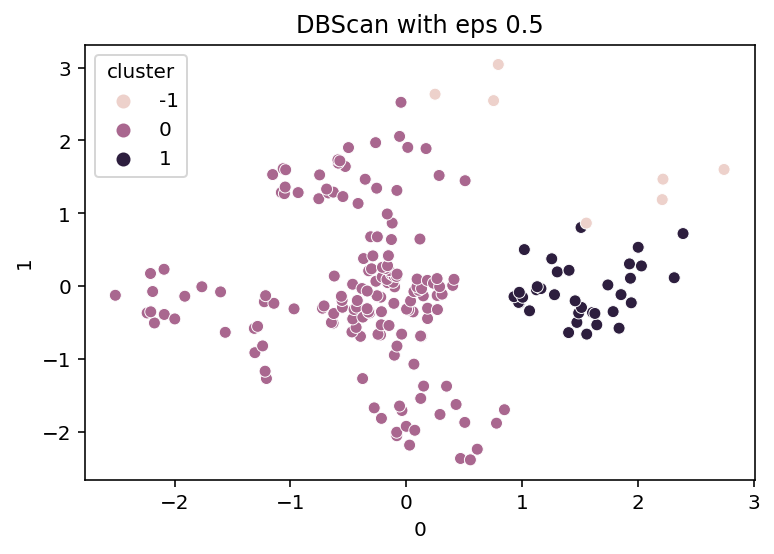

Silhouette Coefficient: 0.3451
Davies Bouldin Index: 0.8144


In [31]:
ss = StandardScaler()
scaled_df = pd.DataFrame(ss.fit_transform(reduced_df))

eps = [0.1, 0.2, 0.3, 0.4, 0.5]
for i in eps:
    db = DBSCAN(eps=i, min_samples=4)
    cluster = db.fit(scaled_df)
    cluster_id = pd.DataFrame(cluster.labels_)
    
    d3 = pd.DataFrame()
    d3 = pd.concat([scaled_df,cluster_id],axis=1)
    d3.columns = [0, 1, "cluster"]
    
    sns.scatterplot(d3[0], d3[1], hue = d3['cluster'], legend="full")
    plt.title('DBScan with eps {}'.format(i))
    plt.show()
    
    print('Silhouette Coefficient: {:.4f}'.format(metrics.silhouette_score(d3.iloc[:,:-1], d3['cluster'])))
    print('Davies Bouldin Index: {:.4f}'.format(metrics.davies_bouldin_score(d3.iloc[:,:-1], d3['cluster'])))

## 3. Hierarchical agglomerative clustering

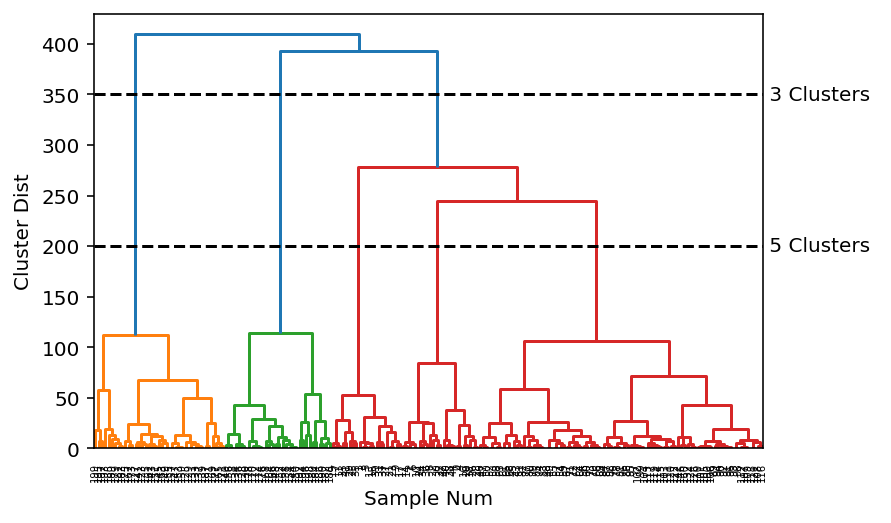

In [32]:
linkage_array = ward(reduced_df)
dendrogram(linkage_array)
plt.xlabel("Sample Num")
plt.ylabel("Cluster Dist")

# 클러스터를 구분하는 커트라인을 표시
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [350, 350], '--', c='k')
ax.plot(bounds, [200, 200], '--', c='k')
ax.text(bounds[1], 350, ' 3 Clusters ', va='center', fontdict={'size': 10})
ax.text(bounds[1], 200, ' 5 Clusters ', va='center', fontdict={'size': 10})
plt.show()

## 4. Agglomerative Clustering

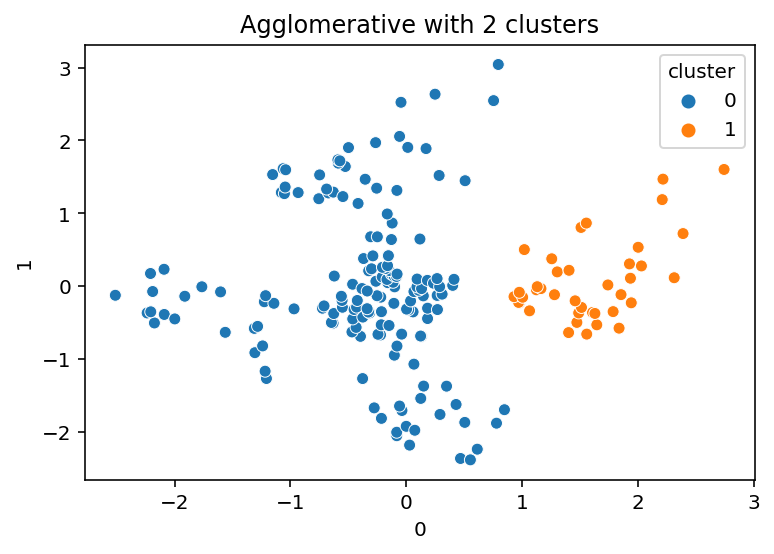

Silhouette Coefficient: 0.3794
Davies Bouldin Index: 0.8542


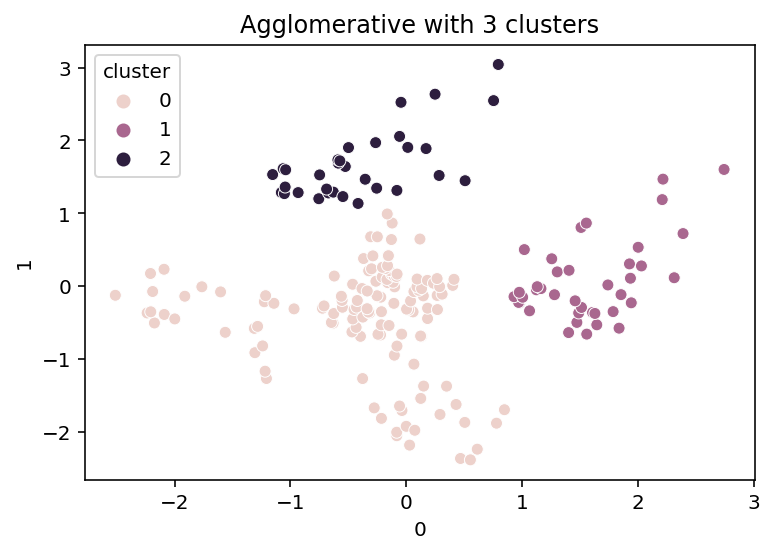

Silhouette Coefficient: 0.4493
Davies Bouldin Index: 0.7163


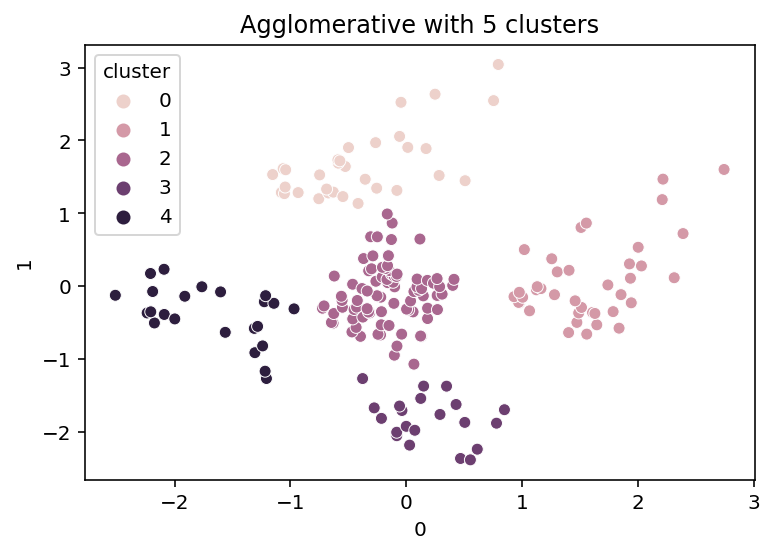

Silhouette Coefficient: 0.5473
Davies Bouldin Index: 0.5902


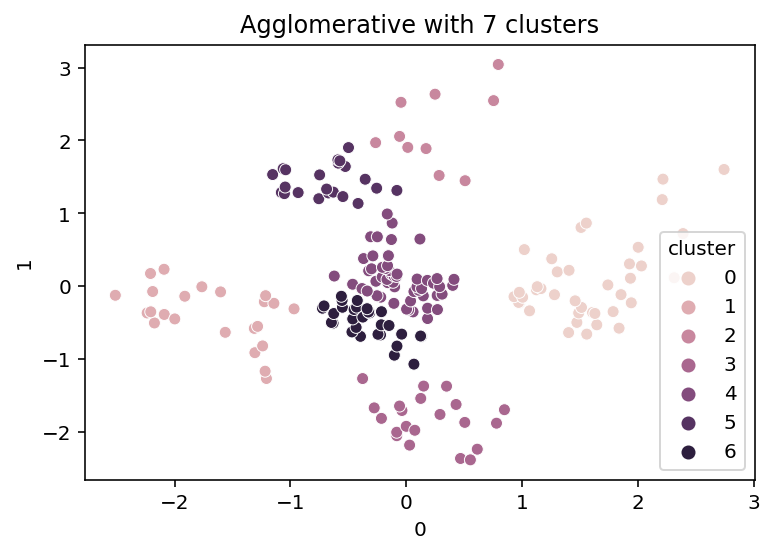

Silhouette Coefficient: 0.4436
Davies Bouldin Index: 0.7269


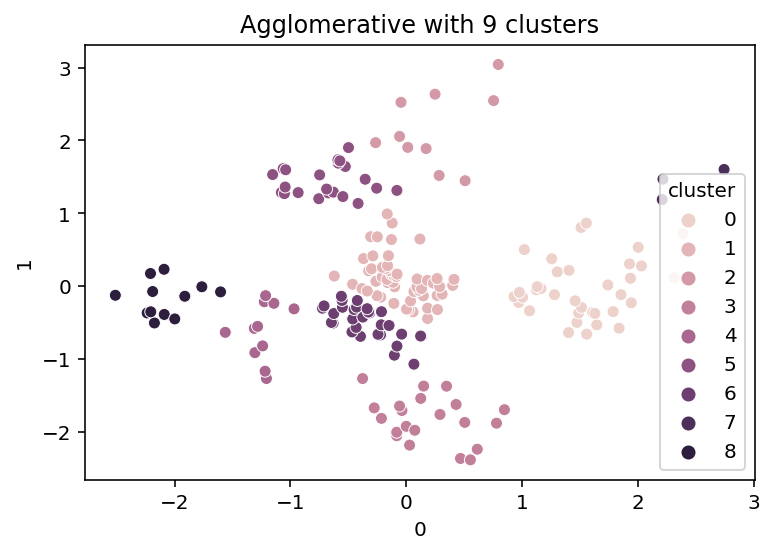

Silhouette Coefficient: 0.4532
Davies Bouldin Index: 0.6974


In [33]:
n = [2,3,5,7,9]
for i in n:
    agg = AgglomerativeClustering(n_clusters=i)
    cluster = agg.fit(scaled_df)
    cluster_id = pd.DataFrame(cluster.labels_)
    
    d4 = pd.DataFrame()
    d4 = pd.concat([scaled_df,cluster_id],axis=1)
    d4.columns = [0, 1, "cluster"]
    
    sns.scatterplot(d4[0], d4[1], hue = d4['cluster'], legend="full")
    plt.title('Agglomerative with {} clusters'.format(i))
    plt.show()
    
    print('Silhouette Coefficient: {:.4f}'.format(metrics.silhouette_score(d4.iloc[:,:-1], d4['cluster'])))
    print('Davies Bouldin Index: {:.4f}'.format(metrics.davies_bouldin_score(d4.iloc[:,:-1], d4['cluster'])))

## 5. Affinity Propagation

* 모든 데이터가 특정한 기준에 따라 자신을 대표할 대표 데이터를 선택한다.
* 만약 스스로가 자기 자신을 대표하게 되면 클러스터의 중심이 된다.  
참고 : https://scikitlearn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation

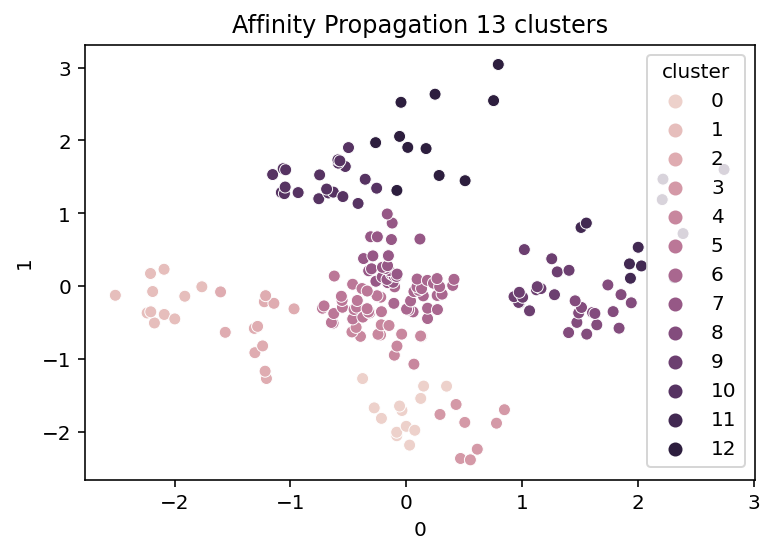

Silhouette Coefficient: 0.4319
Davies Bouldin Index: 0.7753


In [34]:
ap = AffinityPropagation()
cluster = ap.fit(scaled_df)
cluster_id = pd.DataFrame(cluster.labels_)

d5 = pd.DataFrame()
d5 = pd.concat([scaled_df,cluster_id],axis=1)
d5.columns = [0, 1, "cluster"]

sns.scatterplot(d5[0], d5[1], hue = d5['cluster'], legend="full")
plt.title('Affinity Propagation {} clusters'.format(len(d5.cluster.unique())))
plt.show()

print('Silhouette Coefficient: {:.4f}'.format(metrics.silhouette_score(d5.iloc[:,:-1], d5['cluster'])))
print('Davies Bouldin Index: {:.4f}'.format(metrics.davies_bouldin_score(d5.iloc[:,:-1], d5['cluster'])))

## 6. Mean Shift

* 각 점들에 대해 데이터의 분포에서 mode를 찾아 이동하다보면 점들이 적당하게 모일 것이라는 것이라는 아이디어
* bandwidth : 얼마나 관대하게 봐줄지를 설정하는 폭  
참고 : https://scikitlearn.org/stable/modules/generated/sklearn.cluster.MeanShift.html#sklearn.cluster.MeanShift

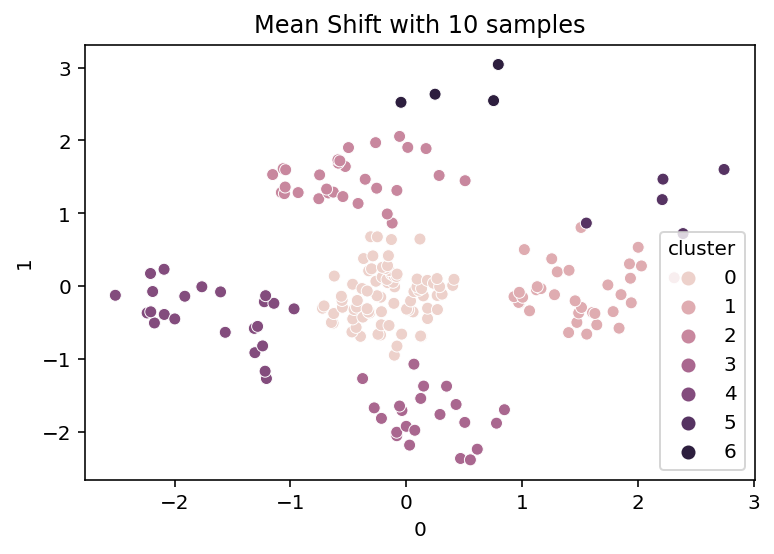

Silhouette Coefficient: 0.5349
Davies Bouldin Index: 0.5895


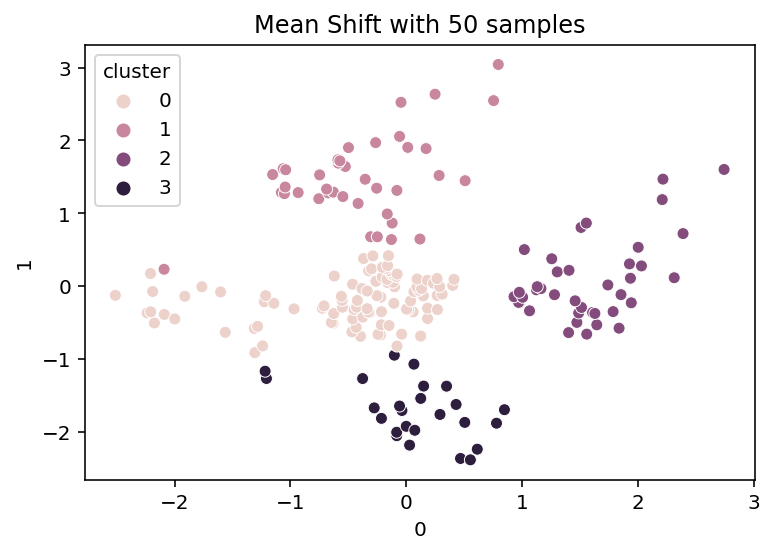

Silhouette Coefficient: 0.4852
Davies Bouldin Index: 0.7207


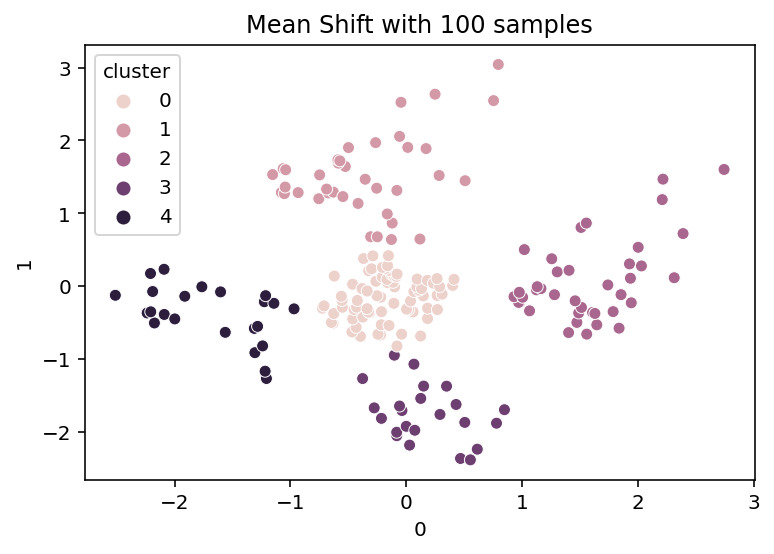

Silhouette Coefficient: 0.5421
Davies Bouldin Index: 0.5857


In [35]:
n = [10, 50, 100]    
for i in n:
    bandwidth = estimate_bandwidth(scaled_df, quantile=0.2, n_samples=i)
    ms = MeanShift(bandwidth=bandwidth)
    cluster = ms.fit(scaled_df)
    cluster_id = pd.DataFrame(cluster.labels_)

    d6 = pd.DataFrame()
    d6 = pd.concat([scaled_df,cluster_id],axis=1)
    d6.columns = [0, 1, "cluster"]

    sns.scatterplot(d6[0], d6[1], hue = d6['cluster'], legend="full")
    plt.title('Mean Shift with {} samples'.format(i))
    plt.show()

    print('Silhouette Coefficient: {:.4f}'.format(metrics.silhouette_score(d6.iloc[:,:-1], d6['cluster'])))
    print('Davies Bouldin Index: {:.4f}'.format(metrics.davies_bouldin_score(d6.iloc[:,:-1], d6['cluster'])))

# Evaluation

### Non-Scaled Data

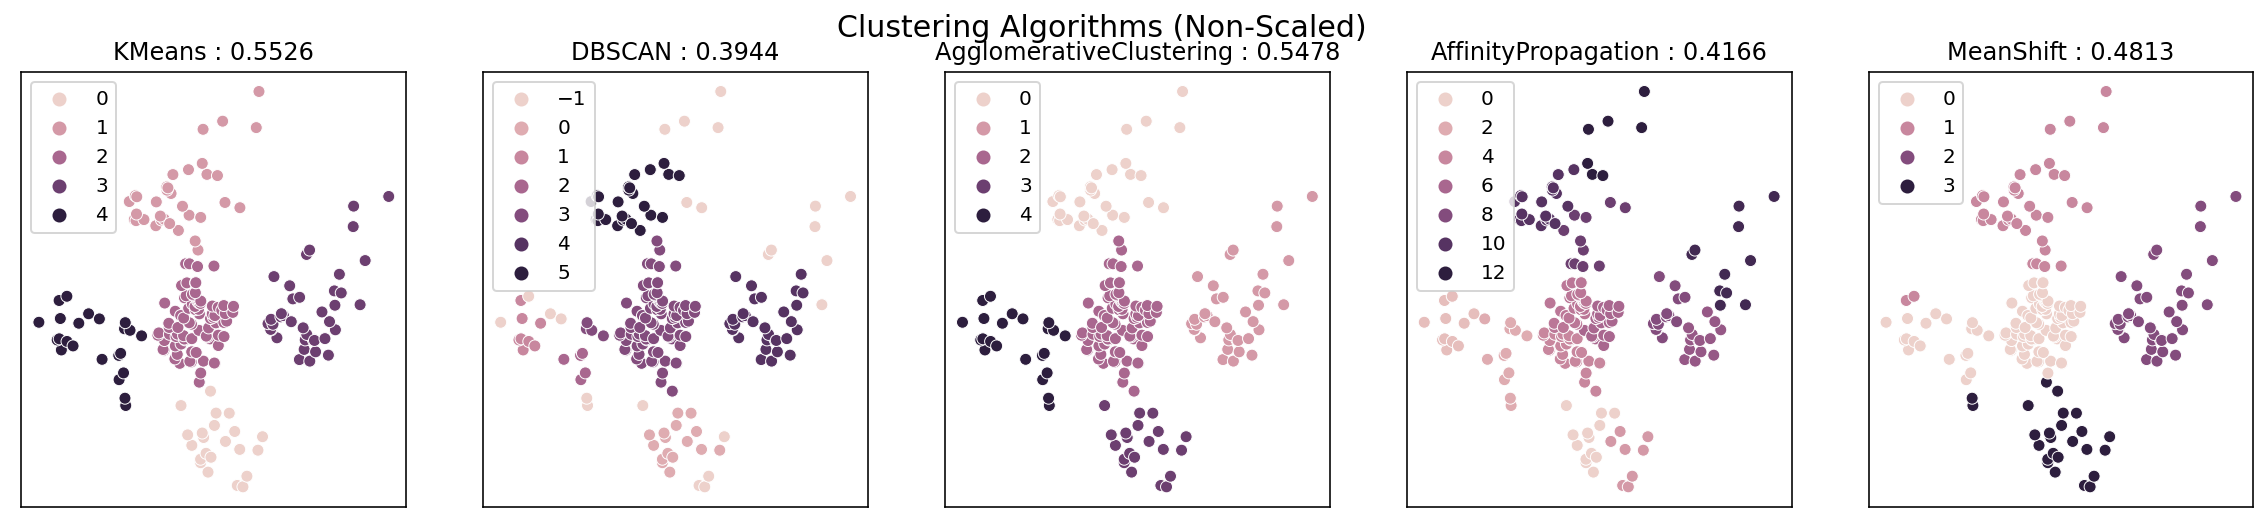

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4), subplot_kw={'xticks': (), 'yticks': ()})
fig.suptitle('Clustering Algorithms (Non-Scaled)', fontsize=15)

algorithms = [KMeans(n_clusters=5, init='k-means++'), 
              DBSCAN(eps=8, min_samples=4),
              AgglomerativeClustering(n_clusters=5),
              AffinityPropagation(),
              MeanShift(bandwidth=estimate_bandwidth(reduced_df, quantile=0.2, n_samples=100))
              ]

for ax, algorithm in zip(axes.flatten(), algorithms):
    clusters = algorithm.fit_predict(reduced_df)
    sns.scatterplot(reduced_df.loc[:, 0], reduced_df.loc[:, 1], hue=clusters, ax=ax)
    ax.set(title="{} : {:.4f}".format(algorithm.__class__.__name__,
                                      silhouette_score(reduced_df, clusters)))
plt.show()

### Scaled Data

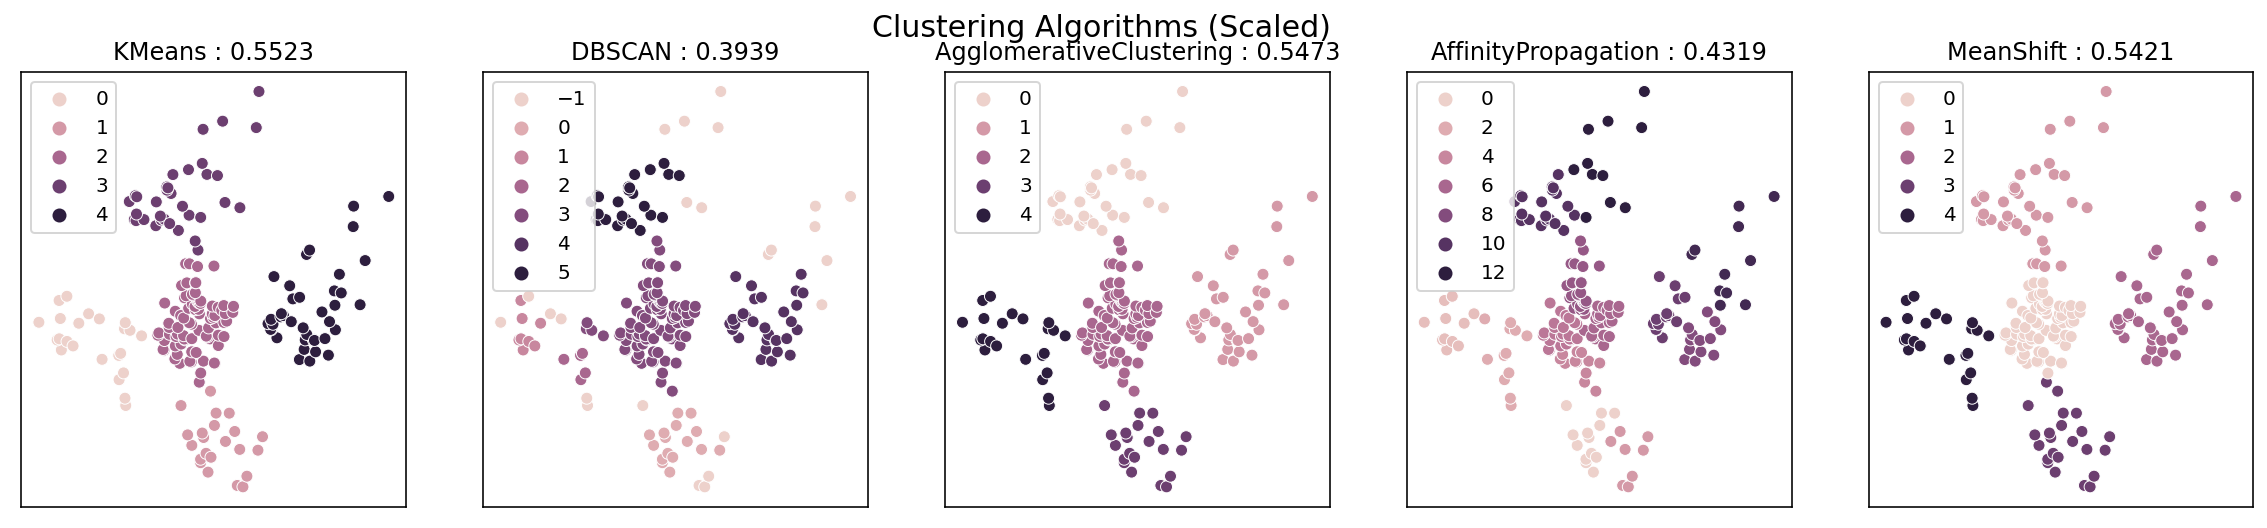

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4), subplot_kw={'xticks': (), 'yticks': ()})
fig.suptitle('Clustering Algorithms (Scaled)', fontsize=15)

algorithms = [KMeans(n_clusters=5, init='k-means++'), 
              DBSCAN(eps=0.3, min_samples=4),
              AgglomerativeClustering(n_clusters=5),
              AffinityPropagation(),
              MeanShift(bandwidth=estimate_bandwidth(scaled_df, quantile=0.2, n_samples=100))
              ]

for ax, algorithm in zip(axes.flatten(), algorithms):
    clusters = algorithm.fit_predict(scaled_df)
    sns.scatterplot(scaled_df.loc[:, 0], scaled_df.loc[:, 1], hue=clusters, ax=ax)
    ax.set(title="{} : {:.4f}".format(algorithm.__class__.__name__,
                                      silhouette_score(scaled_df, clusters)))
plt.show()